In [1327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


# Data Introduction
The dataset is about a direct marketing campaigns in Portuguese. We use the data to apply on a classification task. Based on client information is from phone contact, after several times of contact, we would like to predict if the client finally subscribe the term deposit.

In [1279]:
# read the data
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [1280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We can find the dataset is actually unbalanced between two classes. It makes classifier just need to predict all samples as "no", and it will have a good accuracy. I will show that in the following code. Therefore, balance the data, especially the training set is important to build a good classifier.

In [1281]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

We have 9 categorized features and 7 numical features totally.

In [1282]:
all_cat_attribs=df.select_dtypes(include=['object']).columns.tolist()
all_cat_attribs.remove('y')
all_num_attribs=df.select_dtypes(include=['int64']).columns.tolist()
display(all_cat_attribs,all_num_attribs)

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

We would like to check the distribution of each feature for two classes "yes" and "no". We ploted different values with their frequency ot counts. It is a very important, as it will influence how to normalize this column of data. We can also check the relationships between the feature and two classes briefly, and have a simple idea about it.

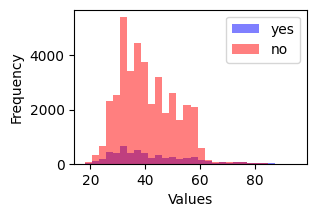

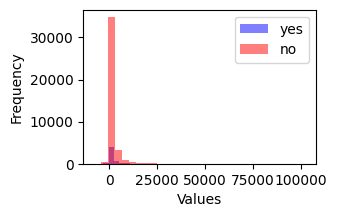

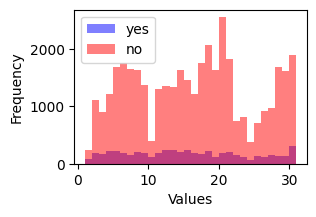

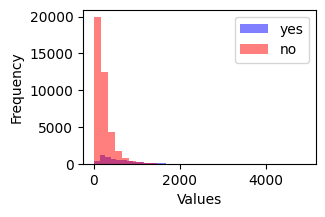

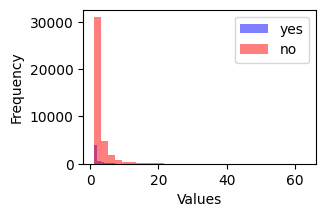

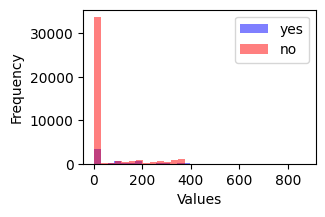

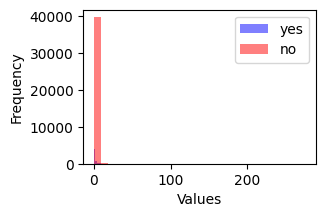

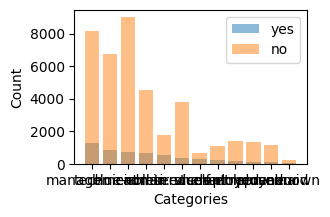

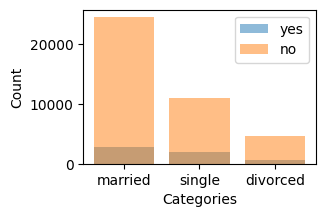

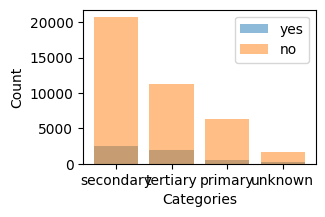

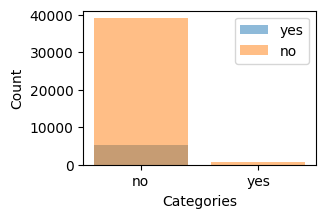

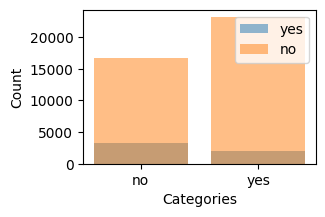

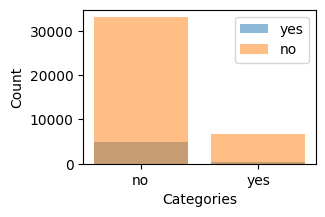

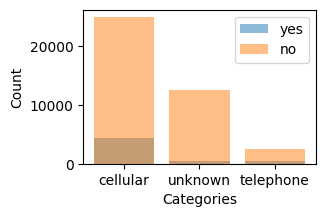

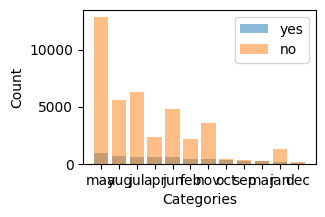

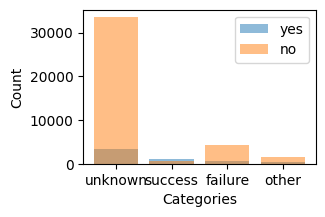

In [1283]:
y_idx=df.index[df["y"]=="yes"].tolist()
n_idx=df.index[df["y"]=="no"].tolist()

df_y=df.iloc[y_idx]
df_n=df.iloc[n_idx]

for col in all_num_attribs:
    plt.figure(figsize=(3, 2))
    plt.hist(df_y[col], bins=30, alpha=0.5, color='blue', label='Class yes')
    plt.hist(df_n[col], bins=30, alpha=0.5, color='red', label='Class no')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend(["yes", "no"])
    plt.show()

for col in all_cat_attribs:
    plt.figure(figsize=(3, 2))
    value_counts_y= df_y[col].value_counts()
    plt.bar(value_counts_y.index, value_counts_y.values,alpha=0.5)
    value_counts_n= df_n[col].value_counts()
    plt.bar(value_counts_n.index, value_counts_n.values,alpha=0.5)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend(["yes", "no"])
    plt.show()
# df.hist(bins=30, figsize=(12, 8))
# plt.show()

## Data Balancing
To balance the data, we select 5000 samples each for two classes randomly, and plot again.

(10000, 17)


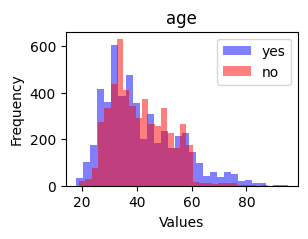

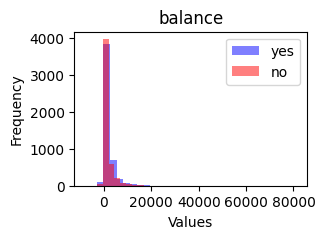

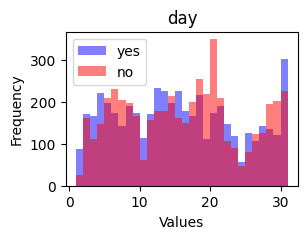

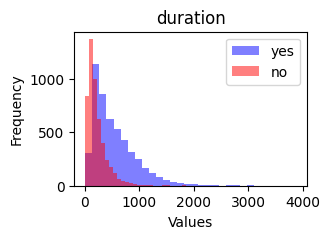

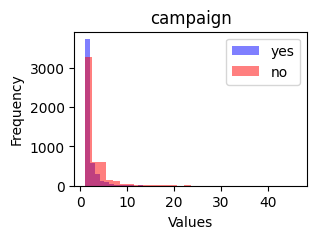

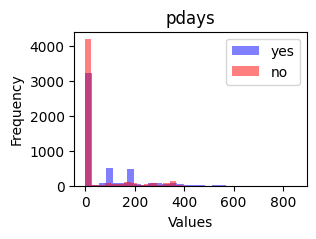

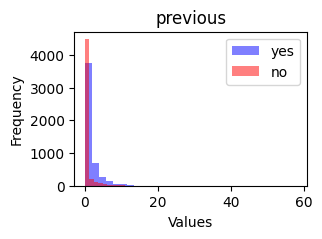

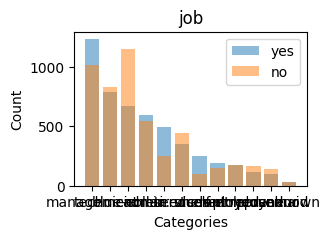

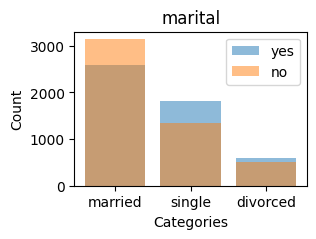

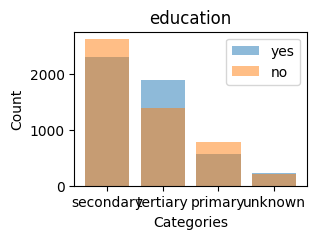

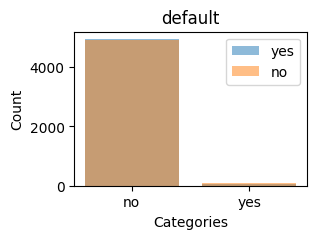

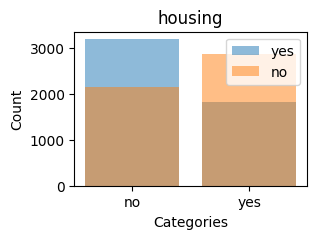

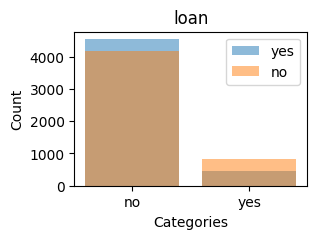

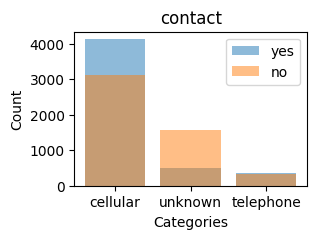

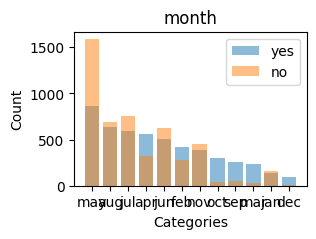

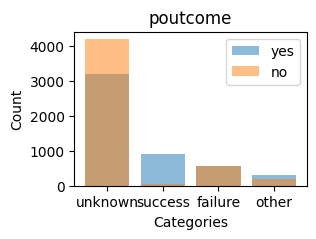

In [1284]:
random.seed(42)
y_idx_selected=random.sample(y_idx,5000)
n_idx_selected=random.sample(n_idx,5000)

df_y=df.iloc[y_idx_selected]
df_n=df.iloc[n_idx_selected]

df_balanced=pd.concat([df_y,df_n])
print(df_balanced.shape)

for col in all_num_attribs:
    plt.figure(figsize=(3, 2))
    plt.hist(df_y[col], bins=30, alpha=0.5, color='blue', label='Class yes')
    plt.hist(df_n[col], bins=30, alpha=0.5, color='red', label='Class no')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend(["yes", "no"])
    plt.title(col)
    plt.show()

for col in all_cat_attribs:
    plt.figure(figsize=(3, 2))
    value_counts_y= df_y[col].value_counts()
    plt.bar(value_counts_y.index, value_counts_y.values,alpha=0.5)
    value_counts_n= df_n[col].value_counts()
    plt.bar(value_counts_n.index, value_counts_n.values,alpha=0.5)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title(col)
    plt.legend(["yes", "no"])
    plt.show()

From the previous histogram, we found there are many features have value "known" which is close the meaning of Not a Number("Nan"). Some features have a large number of unknown value, like "poutcome" and "contact", some just have a few. For some just have a few unknow value, we can replace them with mean value or median value in following preprocessing pipeline. For others, we can drop them, as they have too many unknown values. However, after checking the histogram and the description of those features again, we believe they are still useful. For example, for the feature "poutcome", which means the outcome of the previous marketing campaign, we think a man who secceed in last marketing campaign is more likely buy it again this time, the distribution histogram also shows this. So, I kept the "success" and "failure" samples and add "unknown" samples to "other" ones. I also replace all "unknown" with "unavailable", as I would to implement all other "unknown" together, and replace them with NaN. 

In [1286]:
df['poutcome'] = df['poutcome'].replace('unknown', 'other')
df['contact'] = df['contact'].replace('unknown', 'unavailable')
df = df.replace('unknown', np.NaN)
df.isna().sum()

age             0
job           288
marital         0
education    1857
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

In [1178]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unavailable,5,may,261,1,-1,0,other,no
1,44,technician,single,secondary,no,29,yes,no,unavailable,5,may,151,1,-1,0,other,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unavailable,5,may,76,1,-1,0,other,no
3,47,blue-collar,married,NaN,no,1506,yes,no,unavailable,5,may,92,1,-1,0,other,no
4,33,NaN,single,NaN,no,1,no,no,unavailable,5,may,198,1,-1,0,other,no


# Machine Learning Algorithms
## K Nearest Neighbours
First, we try to work on unbalanced data with 70% are training set and 30% are testing set.

In [1180]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

### KNN with Stadard Normalization
In this section, we imputed data for missing values (aka unknown values) by averaging for numical ones and most frequent for categroy ones. We also did standard normalization which makes all values in a column have 0 mean and unit standard deviation. All these preprocessing are done on the training data.

In [1181]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

X = train_set.drop('y', axis=1)
y = train_set['y'].copy()

num_attribs = ["age", "balance", "day","duration", "pdays", "campaign","previous"]
cat_attribs = ["job", "marital", "month","education", "default", "housing", "loan",'contact','poutcome']

num_pipeline = make_pipeline(
     SimpleImputer(strategy="mean"), 
     StandardScaler())

cat_pipeline = make_pipeline(
     SimpleImputer(strategy="most_frequent"),
     OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
     ("num", num_pipeline, num_attribs),
     ("cat", cat_pipeline, cat_attribs)])

X_transformed = preprocessing.fit_transform(X)


We then apply the data on the K nearest neighbour algorithm, with 5 nearest neighbour. Since it is just a simple algorithm, we did not tune the hyperparameters, and just have a brief idea about its performance.

In [1182]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_transformed, y)

KNeighborsClassifier()

### Unbalanced training with unbalanced testing
The following result shows performance our testing data applied on KNN algorithm. It looks not bad, but we nood to notice we are working on an unbalanced dataset. The data has 39922 samples with label "no" among 45211 samples totally, which means if we just predict with "no", we will have a accuracy of 88.3%. So, the performance is actually not outstanding enough. However, unbalance data is not useless, as in real world, data is not balanced itself, we need to select depends on our needs.

0.8965644352698319


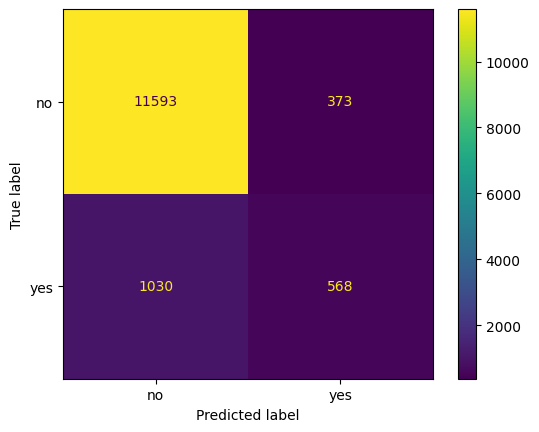

In [1183]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

X_test = test_set.drop("y", axis=1)
y_test = test_set["y"].copy()
X_test_transformed = preprocessing.transform(X_test)
y_pred = neigh.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Balanced training with balanced testing
In this section, we use the balanced data with 5000 samples in each class, and use same preprocess steps and KNN model. Finally we get a performance with 81% accuracy. We can also get a 78.2% precision and 84.7% recall. The accuracy is not bad, and precision and recall will be used for more comparasion in the following section.

0.81


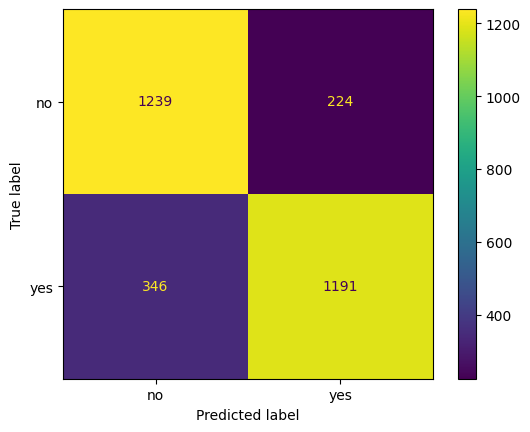

In [1184]:
df_balanced['poutcome'] = df_balanced['poutcome'].replace('unknown', 'other')
df_balanced['contact'] = df_balanced['contact'].replace('unknown', 'unavailable')
df_balanced = df_balanced.replace('unknown', np.NaN)
df_balanced_new=df_balanced
train_set_balanced, test_set_balanced = train_test_split(df_balanced_new, test_size=0.3, random_state=42)
X_balanced = train_set_balanced.drop('y', axis=1)
y_balanced = train_set_balanced['y'].copy()
X_transformed_balanced = preprocessing.fit_transform(X_balanced)
neigh2 = KNeighborsClassifier(n_neighbors=5)
neigh2.fit(X_transformed_balanced, y_balanced)
X_test_balanced = test_set_balanced.drop("y", axis=1)
y_test_balanced = test_set_balanced["y"].copy()
X_test_transformed_balanced = preprocessing.transform(X_test_balanced)
y_pred_balanced = neigh2.predict(X_test_transformed_balanced)
print(accuracy_score(y_test_balanced, y_pred_balanced))

ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced)
plt.show()

### Unbalanced training with balanced testing
To show how this model is better than previous one, we predict the same data but use the previous model which trained by unbalanced data. As a result we just get a 65.0 % of accuracy. the recall is 99.0% and the precision is 58.3%. The model predict 82.8% of testing data as no, very close to original 88.3% in the whole data.

0.6496666666666666


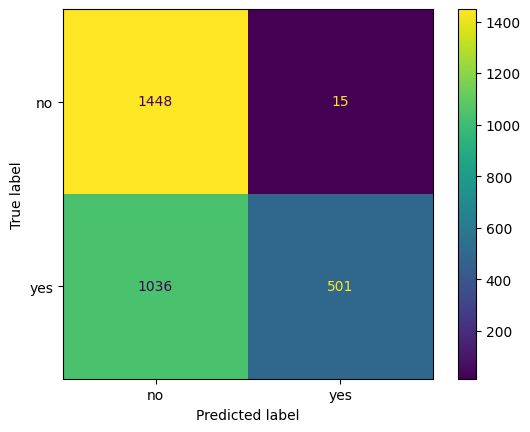

In [1185]:
# accuracy on old model fit with balanced data
y_pred_balanced_prime = neigh.predict(X_test_transformed_balanced)
print(accuracy_score(y_test_balanced, y_pred_balanced_prime))
ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced_prime)
plt.show()

### KNN with Customized Normalization
We would like to do more about normalization in this section. Previously, we just applied standard normalization on all numical data, but the performance is not always good,  tbecause the data distribution is different in different columns. From previou histograms, we found "age" have a distribution more like normal one, it has more frequency at mean and less frequency at two sides. "balance" is not that close to normal distribution, but the value can be any one even infinite at two sides, and more samples are close to 0, so we can also normalize then to 0 mean and unit standard deviation. For feature "day", all values have similar frequency with a specific boundary, so we use max and min scaling method to rescalue it. For the rest of features , we found their frequency decreasing when the value get larger, and low values make up most of frequency, so, we use logarithm to rescale the data. What need to notice is the feature "pday" has value "-1", so we add one for every values in that column and apply log1p function. (log(1+x)).

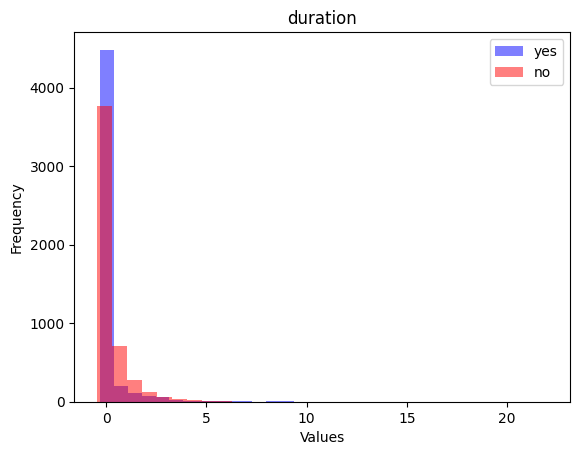

In [1186]:
plt.hist((df_n["previous"] - np.mean(df_n["previous"])) / np.std(df_n["previous"]), bins=30, alpha=0.5, color='blue', label='Class yes')
plt.hist((df_y["previous"] - np.mean(df_y["previous"])) / np.std(df_y["previous"]), bins=30, alpha=0.5, color='red', label='Class no')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(["yes", "no"])
plt.title("duration")
plt.show()

In [1187]:
df_balanced_new["pdays"] = df_balanced_new["pdays"]+1


train_set_balanced, test_set_balanced = train_test_split(df_balanced_new, test_size=0.3, random_state=42)
X_balanced = train_set_balanced.drop('y', axis=1)
y_balanced = train_set_balanced['y'].copy()
X_test_balanced = test_set_balanced.drop("y", axis=1)
y_test_balanced = test_set_balanced["y"].copy()

In [1302]:
num_attribs_1 = ["age", "balance"]
num_attribs_2 = [ "day"]
num_attribs_3 = [ "duration", "pdays", "campaign","previous"]

# Log_transform = FunctionTransformer(np.log1p, validate=True)

num_pipeline_1 = make_pipeline(
     SimpleImputer(strategy="mean"),
     StandardScaler())

num_pipeline_2 = make_pipeline(
     SimpleImputer(strategy="mean"),
     MinMaxScaler())

num_pipeline_3 = make_pipeline(
     SimpleImputer(strategy="mean"),
     FunctionTransformer(np.log1p, validate=True))

preprocessing_1 = ColumnTransformer([
     ("num_1", num_pipeline_1, num_attribs_1),
     ("num_2", num_pipeline_2, num_attribs_2),
     ("num_3", num_pipeline_3, num_attribs_3),
     ("cat", cat_pipeline, cat_attribs)])


X_transformed_balanced_1 = preprocessing_1.fit_transform(X_balanced)
neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh3.fit(X_transformed_balanced_1, y_balanced)

X_test_transformed_balanced_1 = preprocessing_1.transform(X_test_balanced)
y_pred_balanced_1 = neigh3.predict(X_test_transformed_balanced_1)
accuracy_score(y_test_balanced, y_pred_balanced_1)

0.8093333333333333

The customized preprocrssing brings us a accuracy of 80.9%, which is even not as good as pervious one. However, we also found the new prediction has different precision and recall. This time, we have precision: 79.8%, and recall: 81.5%. This is because our new normalization changed the distinguishability of the related features. Two types of scaling methods preserved different information and distinguishability, and no one of them can be always fit our data. 

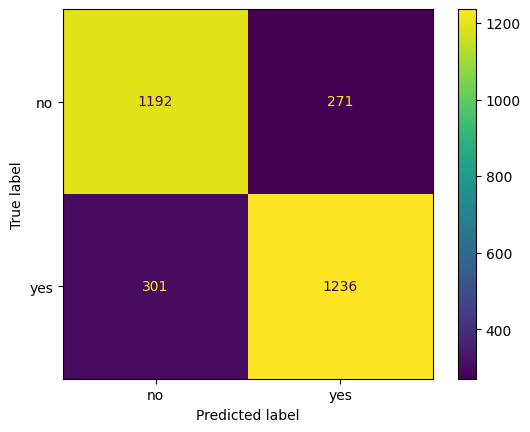

In [1303]:
ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced_1)

plt.show()

## Support Vector Machine
We then would like to find the performance the data work on other machine learning algorithms. We use Support Vector Machine(SVM) for the next. First we replace the label "yes" and "no" with 1 and -1 so that we can use SVM.

In [1190]:
y_balanced_svm=y_balanced
y_balanced_svm=y_balanced_svm.replace("yes",1)
y_balanced_svm=y_balanced_svm.replace("no",-1)
y_test_balanced_svm=y_test_balanced
y_test_balanced_svm=y_test_balanced_svm.replace("yes",1)
y_test_balanced_svm=y_test_balanced_svm.replace("no",-1)

### SVM on balanced data
The accuracy get from SVM improved a lot, get a 84.0%. I will analyse other information we get in the following section, as we would to tune the model by cross validation.

In [1307]:
from sklearn import svm

SvmClf = svm.SVC(random_state=42)
SvmClf.fit(X_transformed_balanced_1,  y_balanced_svm)
svm_y = SvmClf.predict(X_test_transformed_balanced_1)
accuracy_score(y_test_balanced_svm, svm_y)

0.8396666666666667

The SVM also shows general standard  normalization has a better distinguishability for two classes and we get a 85.5% accuracy on testing data.

In [1308]:
SvmClf_prime = svm.SVC(random_state=42)
SvmClf_prime.fit(X_transformed_balanced, y_balanced_svm)
svm_y_prime = SvmClf_prime.predict(X_test_transformed_balanced)
accuracy_score(y_test_balanced_svm, svm_y_prime)
# ConfusionMatrixDisplay.from_predictions(y_test_balanced, y_pred_balanced)

0.855

We tune the two SVM model with two groups of data that has different method, and we get two groups of hyperparameters. The performances of them are similar but old one still has a better result. So, in the following task, we will just use data with standard normalization. Again, it has 85.5% of accuracy with 86.1% of precision and 83.7% of recall, which is best general performance performance we get from balanced data, and just(KNN has a little better recall).

In [1164]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'C': [0.1, 1, 10,100,1000],
# 'degree':[1, 2, 3, 4],
'kernel': ['poly', 'rbf', 'sigmoid'],
'gamma': ['scale', 'auto'],
'decision_function_shape':['ovo','ovr'],
},]

SvmGrid = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
SvmGrid.fit(X_transformed_balanced_1,  y_balanced_svm)
y_pred_cv = SvmGrid.predict(X_test_transformed_balanced_1)

# print best tuned parameter
print(SvmGrid.best_params_)
  
# print bes SVM model
print(SvmGrid.best_score_)
accuracy_score(y_test_balanced_svm, y_pred_cv)

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}
0.8492857142857142


0.8473333333333334

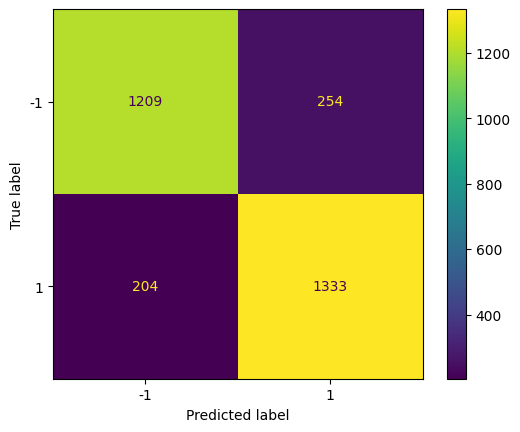

In [1314]:
ConfusionMatrixDisplay.from_predictions(y_test_balanced_svm, y_pred_cv)

In [1309]:
SvmGrid_2 = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
SvmGrid_2.fit(X_transformed_balanced,  y_balanced_svm)
y_pred_cv_2 = SvmGrid_2.predict(X_test_transformed_balanced)

# print best tuned parameter
print(SvmGrid_2.best_params_)
  
# print bes SVM model
print(SvmGrid_2.best_score_)
accuracy_score(y_test_balanced_svm, y_pred_cv_2)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
0.8527142857142858


0.855

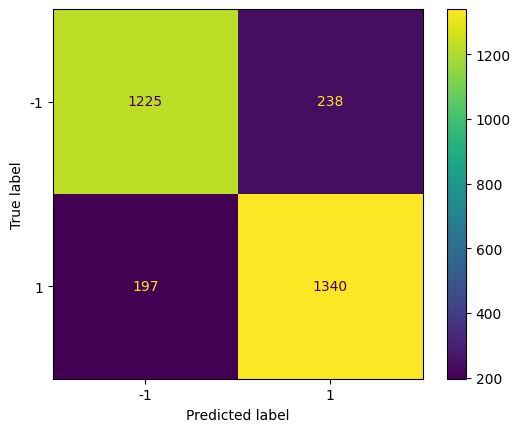

In [1315]:
ConfusionMatrixDisplay.from_predictions(y_test_balanced_svm, y_pred_cv_2)

### SVM on rest unbalanced data
Since our raw data is unbalanced and we did a subsampling to balance the data, there are more rest of data that can be used for testing, and they are unbalanced either. Checking the performance on these data can help us know if our model is able to work well on unbalanced data as well. The result shows on unbalanced testing data, the accuracy are 82.9% and 83.3%, which is very similar to previouse result on balanced testing data. As a result, the model trained on balanced data still works on unbalanced data, but that trained on unbalanced data cannot work well on balanced data.

In [1312]:
df_rest=df.drop(y_idx_selected).drop(n_idx_selected)
df_rest['y'].value_counts()

df_rest['poutcome'] = df_rest['poutcome'].replace('unknown', 'other')
df_rest['contact'] = df_rest['contact'].replace('unknown', 'unavailable')
df_rest = df_rest.replace('unknown', np.NaN)
X_rest = df_rest.drop('y', axis=1)
y_rest = df_rest['y'].copy()
y_rest=y_rest.replace("yes",1)
y_rest=y_rest.replace("no",-1)
X_rest["pdays"] = X_rest["pdays"]+1
X_rest_transformed=preprocessing_1.transform(X_rest)
y_pred_rest = SvmGrid.predict(X_rest_transformed)
accuracy_score(y_rest, y_pred_rest)

0.8294283036551078

In [1313]:
X_rest["pdays"] = X_rest["pdays"]-1
X_rest_transformed_2=preprocessing.transform(X_rest)
y_pred_rest_2 = SvmGrid_2.predict(X_rest_transformed_2)
accuracy_score(y_rest, y_pred_rest_2)

0.833120331714521

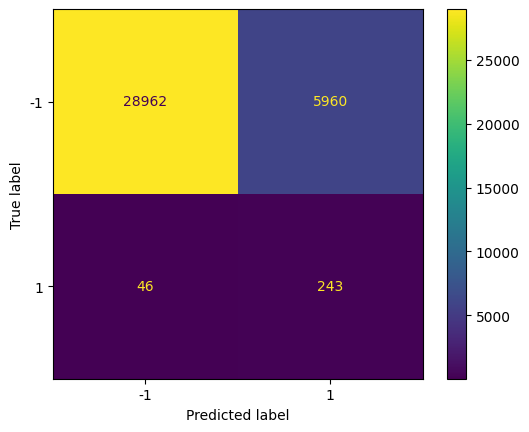

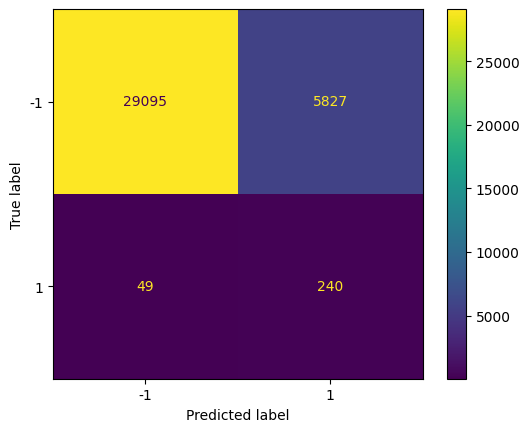

In [1316]:
ConfusionMatrixDisplay.from_predictions(y_rest, y_pred_rest)
ConfusionMatrixDisplay.from_predictions(y_rest, y_pred_rest_2)

plt.show()

0.8113333333333334


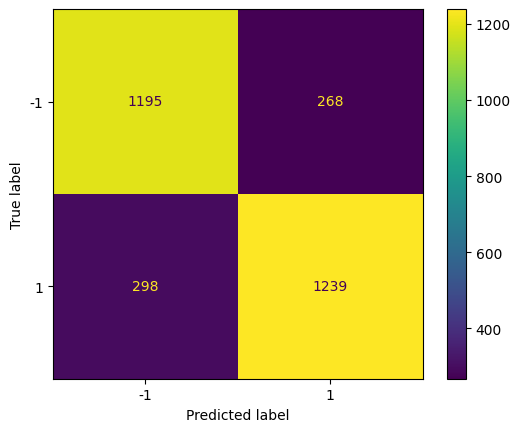

In [1323]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=5, random_state=0)
clf_rf.fit(X_transformed_balanced,  y_balanced_svm)
y_pred_rf=clf_rf.predict(X_test_transformed_balanced)

print(accuracy_score(y_test_balanced_svm, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test_balanced_svm, y_pred_rf)

## Random Forest
In this Section, we generate random forest model for our data, the performance howeber, is not that good. After tuning, the accuracy is just 82.1%, precision is 82.0% and recall is 81.1%. but we believe the performance can be better if we can have more estimators.

In [1328]:
param_grid_rf = [{'n_estimators': [100,200,500],
"criterion":["gini", "entropy", "log_loss"],
"max_depth": [3,4,5],
'min_samples_split': [2,3,4],
'min_samples_leaf':[1,2,3],
},]

RfGrid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
RfGrid.fit(X_transformed_balanced,  y_balanced_svm)
y_pred_cv_rf = RfGrid.predict(X_test_transformed_balanced)

# print best tuned parameter
print(RfGrid.best_params_)
  
# print bes SVM model
print(RfGrid.best_score_)
accuracy_score(y_test_balanced_svm, y_pred_cv_rf)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
0.8244285714285715


0.821

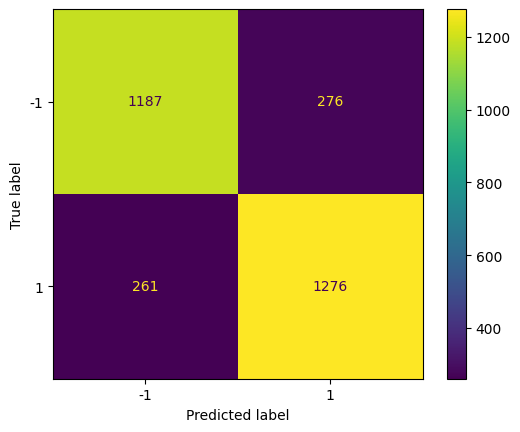

In [1329]:
ConfusionMatrixDisplay.from_predictions(y_test_balanced_svm, y_pred_cv_rf)

## Artificial Neural Networks
To add the variation of mdoels, we also use the Artifical Neural Network. We build a simple neural network and used dropout to avoid overfitting. The label in neural need to convert to 0 and 1, as we used sigmoid function. After 30 epochs, we get a result of accuracy 85.8%, precision is 87.9 and recall is 82.2. Opposite to SVM, ANN brings us a better precision but worse recall, which is useful when we have different needs on the model.

Epoch 1/30
219/219 [==============================] - 1s 1ms/step - loss: 0.5858 - accuracy: 0.6776
Epoch 2/30
219/219 [==============================] - 0s 1ms/step - loss: 0.4596 - accuracy: 0.7973
Epoch 3/30
219/219 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.8167
Epoch 4/30
219/219 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8254
Epoch 5/30
219/219 [==============================] - 0s 1ms/step - loss: 0.4012 - accuracy: 0.8327
Epoch 6/30
219/219 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.8433
Epoch 7/30
219/219 [==============================] - 0s 1ms/step - loss: 0.3857 - accuracy: 0.8423
Epoch 8/30
219/219 [==============================] - 0s 1ms/step - loss: 0.3743 - accuracy: 0.8453
Epoch 9/30
219/219 [==============================] - 0s 1ms/step - loss: 0.3778 - accuracy: 0.8467
Epoch 10/30
219/219 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8531

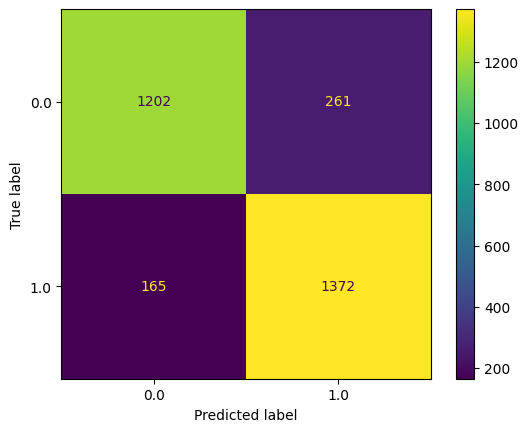

In [1318]:
nn_2=Sequential()
nn_2.add(Dense(64,activation='relu',input_shape=(X_transformed_balanced_1.shape[1],)))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(256,activation='relu'))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(32,activation='relu'))
nn_2.add(Dropout(0.5))
nn_2.add(Dense(1,activation='sigmoid'))

nn_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_2.fit(X_transformed_balanced,  (y_balanced_svm+1)/2,epochs=30)
nn_pred_2=np.round(nn_2.predict(X_test_transformed_balanced))
print(accuracy_score((y_test_balanced_svm+1)/2, nn_pred_2))
ConfusionMatrixDisplay.from_predictions((y_test_balanced_svm+1)/2, nn_pred_2)

plt.show()

## Ensemble Result
From the previous models, we found differnt model have their own strength. Like the SVM model more focus on having less flase negative, so it has better recall. In contast, ANN model has less flase positive, so, it has better precision. Therefore, we are wondering, if we can balance the strength between different models. So, we use simple ensemble methods, majority vote, on three models(SVM,ANN,Random Forest). However, this method, cannot give us a big improvement on accuracy, it is not special either, and it cost too much time and resources. So, it is not that worth to use ensemble method.

0.8543333333333333


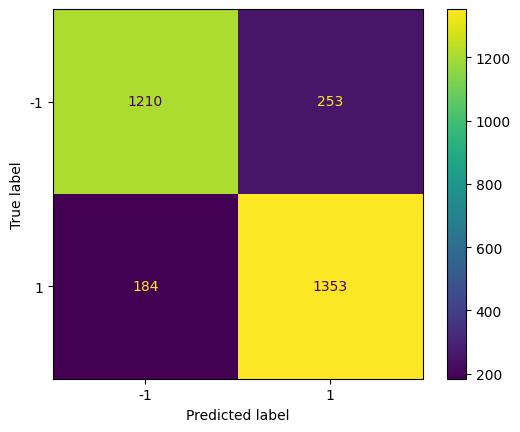

In [1332]:
ems_nn=nn_pred_2*2-1
ems_nn=ems_nn.squeeze().astype(int)
ems_svm=y_pred_cv_2
ems_rf=y_pred_cv_rf
ems_pred=ems_svm+ems_nn+ems_rf
ems_pred[ems_pred> 0] = 1
ems_pred[ems_pred< 0] = -1
print(accuracy_score(np.array(y_test_balanced_svm), ems_pred.astype(int)))
ConfusionMatrixDisplay.from_predictions(np.array(y_test_balanced_svm), ems_pred.astype(int))
plt.show()

In real world, dataset is huge and could be sized in Terabytes. If we would like to run all datasets in machine learning algorithms with all dimensions kept, then it could take very long time and this is very inefficient. To solve the problem, we would like to test different dimensionality reductions methods in the following sections, specifically Fisher Linear Discriminant Analysis and Principal Compoenet Analysis. 

## Fisher Linear Discriminant Analysis (FLD):

Scikitlearn Library does not have the algorithm, so we implemented FLD from scratch.

Fisher Linear Discriminant analysis is a linear dimensionality reduction/extraction method to extract lower-dimensional features which are linear representations of all the dimensions in original data. Fisher Linear Discriminant algorithm attempts to maximize scatters between classes and minimize scatter within classes by calculating scatter matrix of each class. Here is the calculation:

$$S1 = \sum_{i=1}^n (x_1i - mu_1)^T(x_1i - mu_1)\$$
$$S2 = \sum_{i=1}^n (x_2i - mu_2)^T(x_2i - mu_2)\$$

where S1 is scatter matrix of class 1, S2 is scatter matrix of class 2, mu1 is mean of class 1, mu2 is mean of class 2, x1i is one data point in class 1 train data and x2i is one data point in class 2 train data

Sw = S1 + S2, where Sw is scatter within class

For scatter between class:
$$ S_B = N_1 * \sum_{i=1}^n (mu_1 - x_i)^T *(mu_1 - x_i)\ + N_2 * \sum_{i=1}^n (mu_2 - x_i)^T *(mu_2 - x_i)\ $$ 

where xi is train data, N1 is number of class 1 and N2 is number of class2

After getting SW and SB, we perform eigendecompositions so that SB * V = SW * V * D, where D is diagonal matrix and V is full matix with corresponding eigenvectors. We use eigendecompositions becuase we would like to project scatter mattrices to lower dimensions. By sorting V based on eigenvalues in D, we can find most representative/informative eigenvector to the least representative/informative eigenvector 

Finally, we can pick n eigenvectors to transform our dataset. 


Experiment results:

We set up for a threshold (75%) for the performance of tuned SVM, and aimed to reduce as many as dimensions possible and ensure the performance is closed to threshold as the same time. The result is we can keep minimum 22 dimension while maintaining the performance at the threshold. We were able to reduce 54.2% of dimensions as a result.

In [1296]:
from scipy.linalg import eig

# Find the indices of the samples in Y_train that are 1
idx_class1 = np.where(y_balanced_svm == 1)[0]
idx_class2 = np.where(y_balanced_svm == -1)[0]

# Get subset of X_train and Y_train where Y_train is 1
X_train_class1 = X_transformed_balanced_1[idx_class1]
# Get subset of X_train and Y_train where Y_train is -1
X_train_class2 = X_transformed_balanced_1[idx_class2]

# Find means of each class and train data
m = np.mean(X_transformed_balanced_1,axis=0)
m1 = np.mean(X_train_class1,axis=0)
m2 = np.mean(X_train_class2,axis=0)

N_class1 = X_train_class1.shape[0]
N_class2 = X_train_class2.shape[0]

# scatter matrix
S1 = (X_train_class1-m1).T @ (X_train_class1-m1)
S2 = (X_train_class2-m2).T @ (X_train_class2-m2)

# scatter within class
Sw = S1 + S2
# scatter between class
Sb = N_class1*((m1 - X_transformed_balanced_1).T @ (m1 - X_transformed_balanced_1)) + \
N_class2*((m2 - X_transformed_balanced_1).T @ (m2 - X_transformed_balanced_1))

# Peform eigenvalue/eigenvector decomposition
v_FLD, d_FLD = eig(Sb, Sw)
# sort ascending order based on diagonal values
SortedIdx_diag = np.argsort(np.diag(d_FLD))
SortedIdx_diag_reversed = SortedIdx_diag[::-1]
d_FLD_reversed = d_FLD[SortedIdx_diag_reversed]

n_dim = 22
# n-dimensional projection
w_FLD = d_FLD[0:n_dim]
transformed_train_FLD = (X_transformed_balanced_1 - m) @ w_FLD.T
transformed_test_FLD = (X_test_transformed_balanced_1 - m) @ w_FLD.T

In [1297]:
SvmClf_2 = svm.SVC(random_state=42,C=10, decision_function_shape= 'ovo', gamma= 'auto', kernel ='rbf')
SvmClf_2.fit(transformed_train_FLD,  y_balanced_svm)
# accuracy_score(y_test_balanced, y_pred_balanced_1)
svm_y_2 = SvmClf_2.predict(transformed_test_FLD)
print(accuracy_score(y_test_balanced_svm, svm_y_2))
cm = confusion_matrix(y_test_balanced_svm, svm_y_2)

0.758


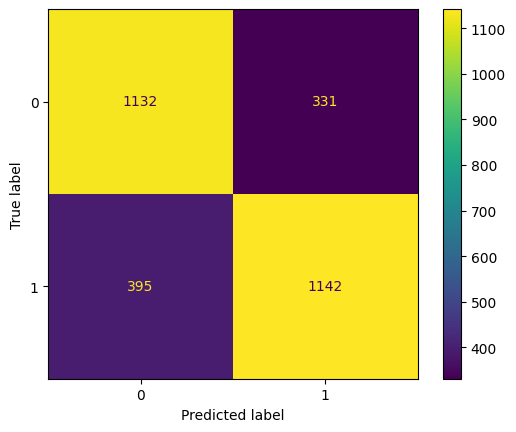

In [1270]:
# use ConfusionMatrixDisplay to display the confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

## Principal Component Analysis (PCA):

Principal Component Analysis is also a linear dimensionality reduction/extraction method and the goal is also to find lower dimensional representations of the original data.

The idea of the algorithm is slightly different from FLD. It takes covariance of train data regardless of class and perform Eigendecompositions (Singular Value Decomposition (SVD) in Scikitlearn library, which is intuitively different but could serve the same purpose) to project data on lower dimensions. 

Experiment results:

With Scikitlearn library, we conducted variance analysis by outputing variance ratio of each dimension. We kept dimensions that have at least 1% of variance and found 13 dimensions that satisfy the requirement. The performance of tuned SVM reached about 80% of accuracy with 16 dimensions. We were able to reduce 72.9% of dimensions.

In [1299]:
from sklearn.decomposition import PCA

pca = PCA(n_components=48)

pca.fit(X_transformed_balanced_1)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[4.36928176e-01 9.25110185e-02 7.42908384e-02 6.75621852e-02
 4.85524467e-02 3.47664295e-02 2.57835302e-02 2.17306479e-02
 1.75313159e-02 1.67366444e-02 1.59784139e-02 1.17881363e-02
 1.15460171e-02 9.87257315e-03 9.67534387e-03 8.85482969e-03
 7.98855509e-03 7.50661905e-03 7.31887206e-03 7.14763541e-03
 6.62215931e-03 6.29738931e-03 6.02908907e-03 5.96230686e-03
 4.63464695e-03 4.50563046e-03 4.11579887e-03 3.78448516e-03
 3.07653749e-03 2.69674142e-03 2.50750696e-03 2.40164766e-03
 2.39173394e-03 2.20750960e-03 2.14183096e-03 2.00824378e-03
 1.86298542e-03 1.80748812e-03 8.76039925e-04 8.61688892e-32
 2.87301627e-33 2.87301627e-33 2.87301627e-33 2.87301627e-33
 2.87301627e-33 2.87301627e-33 2.87301627e-33 2.87301627e-33]
[2.01269607e+02 9.26125630e+01 8.29928736e+01 7.91452793e+01
 6.70932349e+01 5.67744869e+01 4.88927384e+01 4.48858558e+01
 4.03162779e+01 3.93919397e+01 3.84892994e+01 3.30594594e+01
 3.27181901e+01 3.02543866e+01 2.99506586e+01 2.86525500e+01
 2.72149343e+01 2.63812

In [1300]:
pca = PCA(n_components=13)
pca.fit(X_transformed_balanced_1)

transformed_train_PCA = pca.fit_transform(X_transformed_balanced_1)
transformed_test_PCA = pca.fit_transform(X_test_transformed_balanced_1)

SvmClf_2 = svm.SVC(random_state=42,C=10, decision_function_shape= 'ovo', gamma= 'auto', kernel ='rbf')
SvmClf_2.fit(transformed_train_PCA,  y_balanced_svm)
# accuracy_score(y_test_balanced, y_pred_balanced_1)
svm_y_2 = SvmClf_2.predict(transformed_test_PCA)
print(accuracy_score(y_test_balanced_svm, svm_y_2))
cm = confusion_matrix(y_test_balanced_svm, svm_y_2)


0.7993333333333333


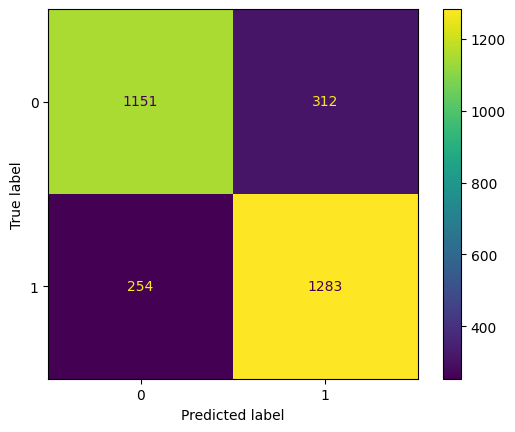

In [1257]:
# use ConfusionMatrixDisplay to display the confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

## Discussions 

Comparing experiement results from PCA and FLD. We found PCA performed better than FLD and we think this is reasonable. The advantage of FLD is that the algorithm can recognize scatters between class and within class; whereas, PCA can only find representative dimensions of the whole dataset. Under some circumstances, such that scatters within classes are larger than scatters between classes, than PCA is not a good approach for dimensionality reduction. However, in this dataset, the condition holds not true and we can already forsee this by observing performance of KNN as KNN measures how separated two classes are.

Consequently, PCA is better and more efficient algorithm to use in this dataset.

# Conclusion

Data balancing is very important, a model trained with balanced data can work on both balanced and unbalanced and testing data. Unless there is a special need.  
Data preprocessing can largely influence the performance, but sound normalization cannot always perform well, as the different distinguishability of data.  
Different models have different strength, even though they have similar performance, select which model largely depends on our needs.  
Basic ensemble methods did not work well, and cost too much. It can be our future work in our task.  
Dimensionality reduction methods are important for computational efficiencies.  

# References

[1] Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

[2] Wu, J. (2020). Essentials of Pattern Recognition: An Accessible Approach. Cambridge: Cambridge University Press. doi:10.1017/   9781108650212